MaxClique Commutator
1.0 * 6 * (Y(0) @ Z(3) + -1 * Y(0)) + 1.0 * 6 * (Y(0) @ Z(4) + -1 * Y(0)) + 1.0 * 6 * Y(0) + 1.0 * 6 * (Y(1) @ Z(3) + -1 * Y(1)) + 1.0 * 6 * Y(1) + 1.0 * 6 * (Y(2) @ Z(4) + -1 * Y(2)) + 1.0 * 6 * Y(2) + 1.0 * 6 * (Z(0) @ Y(3) + -1 * Y(3)) + 1.0 * 6 * (Z(1) @ Y(3) + -1 * Y(3)) + 1.0 * 6 * (Y(3) @ Z(4) + -1 * Y(3)) + 1.0 * 6 * Y(3) + 1.0 * 6 * (Z(0) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * (Z(2) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * (Z(3) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * Y(4)
第1步：能量 = -0.01135527 | β_0 = +0.000000
第2步：能量 = -0.04503813 | β_1 = -1.559365
第3步：能量 = -0.11006312 | β_2 = -3.108475
第4步：能量 = -0.20990739 | β_3 = -4.602594
第5步：能量 = -0.33816912 | β_4 = -5.935704
第6步：能量 = -0.47797184 | β_5 = -6.938677
第7步：能量 = -0.60900021 | β_6 = -7.434001
第8步：能量 = -0.71774667 | β_7 = -7.347373
第9步：能量 = -0.80147048 | β_8 = -6.789024
第10步：能量 = -0.86440847 | β_9 = -6.000338
第11步：能量 = -0.91254741 | β_10 = -5.210561
第12步：能量 = -0.95091354 | β_11 = -4.547534
第13步：能量 = -0.98302206 | β_12 = -4.044553
第1

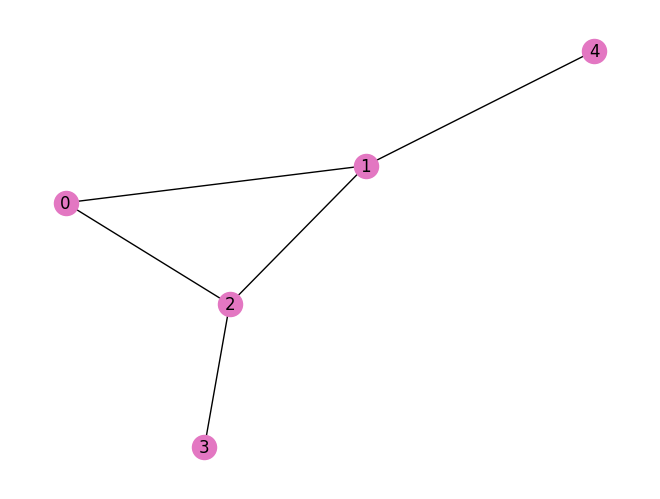

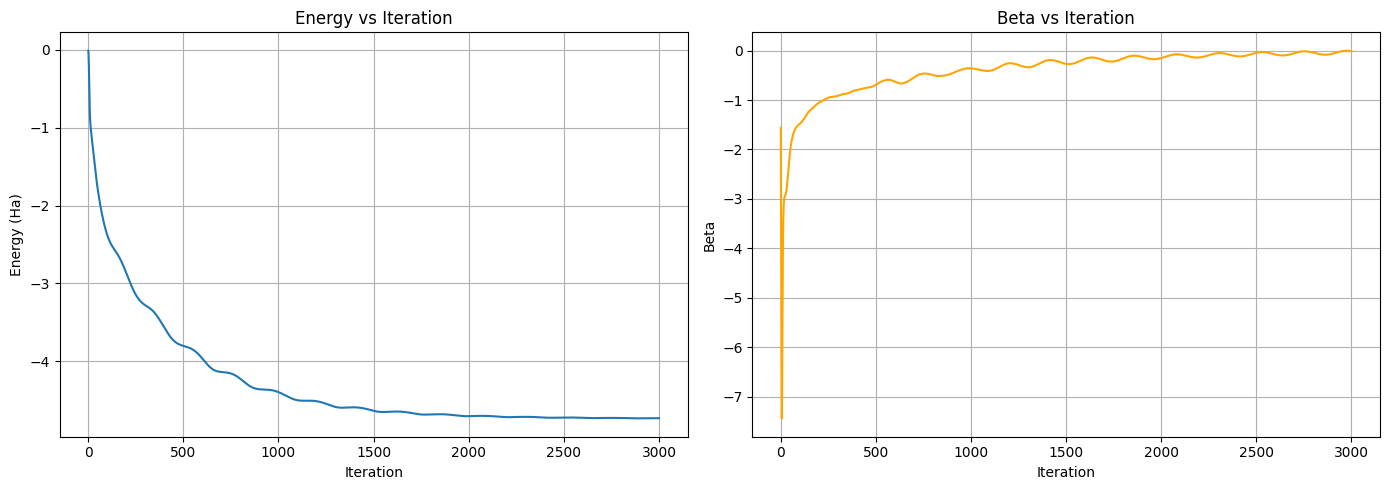

In [21]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx

edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)]
graph = nx.Graph(edges)
positions = nx.spring_layout(graph, seed=1)
nx.draw(graph, with_labels=True, node_color="#e377c2", pos=positions)


cost_h, driver_h = qaoa.max_clique(graph, constrained=False)




def build_hamiltonian(graph):
    H = qml.Hamiltonian([], [])

    # Computes the complement of the graph
    graph_c = nx.complement(graph)

    for k in graph_c.nodes:
        # Adds the terms in the first sum
        for edge in graph_c.edges:
            i, j = edge
            if k == i:
                H += 6 * (qml.PauliY(k) @ qml.PauliZ(j) - qml.PauliY(k))
            if k == j:
                H += 6 * (qml.PauliZ(i) @ qml.PauliY(k) - qml.PauliY(k))
        # Adds the terms in the second sum
        H += 6 * qml.PauliY(k)

    return H


print("MaxClique Commutator")
print(build_hamiltonian(graph))



def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, delta_t * beta_k, 1)

def build_maxclique_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        layers = len(beta)
        for w in dev.wires:
            qml.Hadamard(wires=w)
        qml.layer(
            falqon_layer,
            layers,
            beta,
            cost_h=cost_h,
            driver_h=driver_h,
            delta_t=delta_t
        )

    return ansatz


def expval_circuit(beta, measurement_h):
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)


def max_clique_falqon(graph, n, beta_1, delta_t, dev):
    comm_h = build_hamiltonian(graph) # Builds the commutator
    cost_h, driver_h = qaoa.max_clique(graph, constrained=False) # Builds H_c and H_d
    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd") # The ansatz + measurement circuit is executable

    beta = [beta_1] # Records each value of beta_k
    energies = [] # Records the value of the cost function at each step

    for i in range(n):
        # Adds a value of beta to the list and evaluates the cost function
        beta.append(-1 * cost_fn(beta, measurement_h=comm_h))  # this call measures the expectation of the commuter hamiltonian
        energy = cost_fn(beta, measurement_h=cost_h)  # this call measures the expectation of the cost hamiltonian
        energies.append(energy)
        print(f"第{i + 1}步：能量 = {energy:.8f} | β_{i} = {beta[i]:+.6f}")
    return beta, energies

n = 3000
beta_1 = 0.0
delta_t = 0.01

dev = qml.device("default.qubit", wires=graph.nodes) # Creates a device for the simulation
res_beta, res_energies = max_clique_falqon(graph, n, beta_1, delta_t, dev)


iterations = list(range(1, len(res_energies) + 1))

# 创建两个子图
plt.figure(figsize=(14, 5))

# 第一个子图：Energy vs Iteration
plt.subplot(1, 2, 1)
plt.plot(iterations, res_energies)
plt.title('Energy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Energy (Ha)')
plt.grid(True)

# 第二个子图：Beta vs Iteration
plt.subplot(1, 2, 2)
plt.plot(iterations, res_beta[1:], color='orange')
plt.title('Beta vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Beta')
plt.grid(True)

plt.tight_layout()
plt.show()